<a href="https://colab.research.google.com/github/rahul078/ML-and-DL/blob/main/multi_class_classification_using_chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pwd
!mkdir /content/covid
!mkdir covid/train
!mkdir covid/test

/content


In [ ]:
!unzip drive/MyDrive/x-ray_chest/train.zip -d /content/covid/train
!unzip drive/MyDrive/x-ray_chest/test.zip -d /content/covid/test

Streaming output truncated to the last 5000 lines.
  inflating: /content/covid/train/PNEUMONIA/person1160_bacteria_3105.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1160_virus_1947.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1161_virus_1948.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1162_bacteria_3107.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1162_virus_1949.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1162_virus_1950.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1163_virus_1951.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_bacteria_3110.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_virus_1952.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_virus_1955.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_virus_1956.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_virus_1957.jpeg  
  inflating: /content/covid/train/PNEUMONIA/person1164_virus_195

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dropout
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score, precision_score, accuracy_score, classification_report
from keras.models import model_from_json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
DIRECTORY_TRAIN = "/content/covid/train"
DIRECTORY_TEST = "/content/covid/test"
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 64
NUM_CLASSES = 4
DROUPOUT_RATE = 0.3

In [ ]:
from PIL import Image
image = Image.open("/content/covid/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print(image.size)

(1152, 760)


In [ ]:
train = ImageDataGenerator(
        rotation_range=0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
    validation_split=0.2)
selectedClasses = ["COVID19","NORMAL","PNUEMONIA","TURBERCULOSIS"]

In [ ]:
batchSize=32


train_generator = train.flow_from_directory(
    DIRECTORY_TRAIN,
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='training') # set as training data

validation_generator = train.flow_from_directory(
    DIRECTORY_TRAIN, # same directory as training data
    target_size=(224, 224),
    batch_size=batchSize,
    classes=selectedClasses,
    subset='validation') # set as validation data

test_generator = ImageDataGenerator().flow_from_directory(
    DIRECTORY_TEST, 
    target_size=(224,224), 
    classes=selectedClasses,
    shuffle= False,
    batch_size = batchSize)

Found 1961 images belonging to 4 classes.
Found 490 images belonging to 4 classes.
Found 381 images belonging to 4 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = True

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(len(selectedClasses), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [ ]:
modelName= "InceptionWeight"

filepath=modelName+"_bestweights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
stepsPerEpoch= (train_generator.samples+ (batchSize-1)) // batchSize
print("stepsPerEpoch: ", stepsPerEpoch)

validationSteps=(validation_generator.samples+ (batchSize-1)) // batchSize
print("validationSteps: ", validationSteps)

stepsPerEpoch:  62
validationSteps:  16


In [ ]:
validation_generator.reset()
history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator,
    epochs = 3,
    steps_per_epoch = stepsPerEpoch,
    validation_steps= validationSteps,
    callbacks=callbacks_list,
    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/3
62/62 [==============================] - 938s 15s/step - loss: 0.2670 - accuracy: 0.9046 - val_loss: 2.2367 - val_accuracy: 0.6102
Epoch 2/3
62/62 [==============================] - 925s 15s/step - loss: 0.0681 - accuracy: 0.9760 - val_loss: 0.5271 - val_accuracy: 0.8633
Epoch 3/3
62/62 [==============================] - 922s 15s/step - loss: 0.0498 - accuracy: 0.9822 - val_loss: 0.0363 - val_accuracy: 0.9878


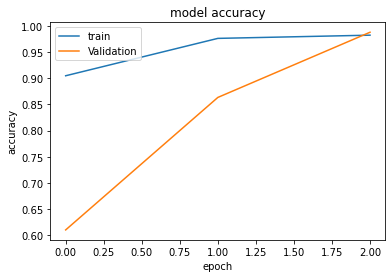

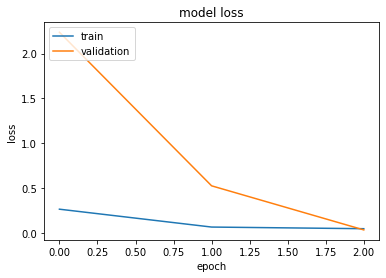

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
model_json = model.to_json()
with open(timestr+"_"+modelName+"_MODEL_3"+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(timestr+"_"+modelName+"_3_LAST_WEIGHTS_"+".h5")

In [ ]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batchSize-1)) //batchSize)
print("For validation data set; Loss: ",score[0]," Accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


For validation data set; Loss:  0.04126204177737236  Accuracy:  0.9836734533309937


In [ ]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batchSize-1)) // batchSize)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


For test data set; Loss:  0.06229858100414276  Accuracy:  0.9790025949478149
